In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Read data

In [2]:
# read files
data_file = "SHOTS_FOR_NMO"
data = np.fromfile(data_file, dtype=np.float32)

elev_file = "ELEV.txt"
elev = pd.DataFrame(data=np.loadtxt(elev_file), 
             columns=["source number", "receiver number", "source elevation (m)", "receiver elevation (m)"])



# define constants
dt = 0.004    # sec
dx = 50    # meter
v = 3000   # velocity

n_shots = 120    # number of shots
n_rec = 60    # channels (traces) per shot
n_samples = 601


# create a vector of seconds
times = np.arange(n_samples) * dt


# reshape to 2D array so each column is a trace
data = data.reshape((n_samples, -1), order="F")

# Display seismograms of common shot gathers

In [3]:
def plot_seismic(data, title=None, ax=None, figsize=(16,9), xticks=None, xlabel=None, show_yticks=False):
    
    """
    """
    
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)

    ax.imshow(data, aspect="auto", cmap="seismic")
    ax.set_title(title, fontsize=16)
    ax.xaxis.set_label_position("top") 
    ax.xaxis.tick_top()
    
    if not xticks is None:
        
        x_idx = np.linspace(0, len(xticks)-1, 7, dtype=int)
        ax.set_xticks(ticks=x_idx)
        ax.set_xticklabels(labels=xticks[x_idx])
        ax.set_xlabel(xlabel, fontsize=10, labelpad=10)
    
    if show_yticks:
        ax.set_yticks(ticks=np.arange(n_samples)[::100])
        ax.set_yticklabels(labels=times[::100])
        ax.set_ylabel("Time [sec]", fontsize=10)

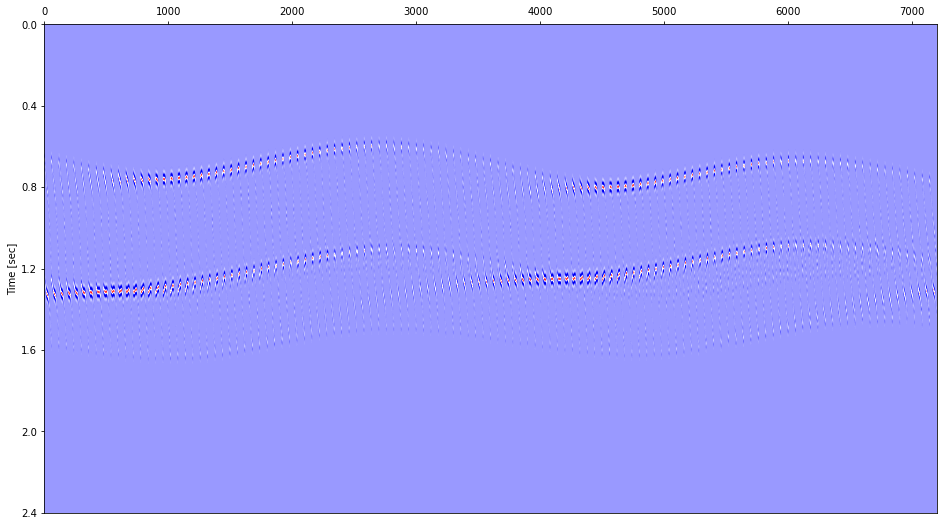

In [4]:
plot_seismic(data, show_yticks=True)

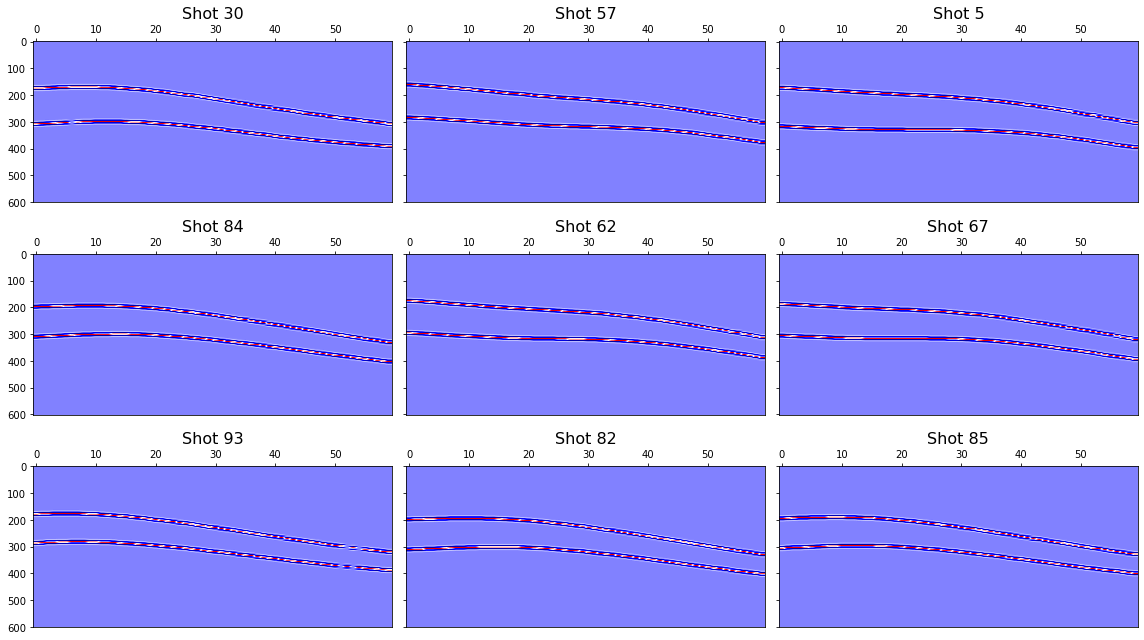

In [5]:
# randomly choose 9 shots to display
disp_shots = np.random.choice(n_shots, size=9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(16,9), sharey=True)
axes = axes.flatten()

for i, ax in zip(disp_shots, axes):
    
    first_idx = i*n_rec
    last_idx = (i+1)*n_rec
    shot_data = data[:, first_idx:last_idx]
    
    plot_seismic(shot_data, title=f"Shot {i+1}", ax=ax)
    

plt.tight_layout()
plt.show()

# Elevation correction for common shot gathers

In [6]:
# calculate datum elevation
datum_elev = min(elev.iloc[:,2].min(), elev.iloc[:,3].min())

# calculate delta for sources and recievers
ds = elev.iloc[:,2] - datum_elev
dr = elev.iloc[:,3] - datum_elev

# calculate time shift for each trace
t_shift = dr/v + ds/v

# calculate shift in terms of data points
n_shift = round(t_shift / dt).astype(int)

# iterate over columns in data, and slice the col starting from the shift index
data_corr = [pd.Series(data[n_shift[i]:,i]) for i in range(data.shape[1])]

# concat all series into data frame and fill nan values with 0
data_corr = pd.concat(data_corr, axis=1).fillna(0).values

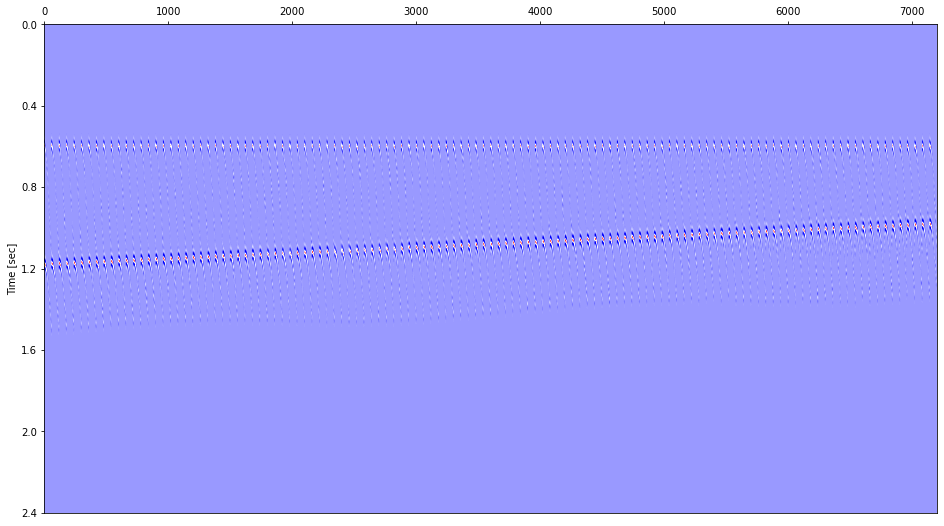

In [7]:
plot_seismic(data_corr, show_yticks=True)

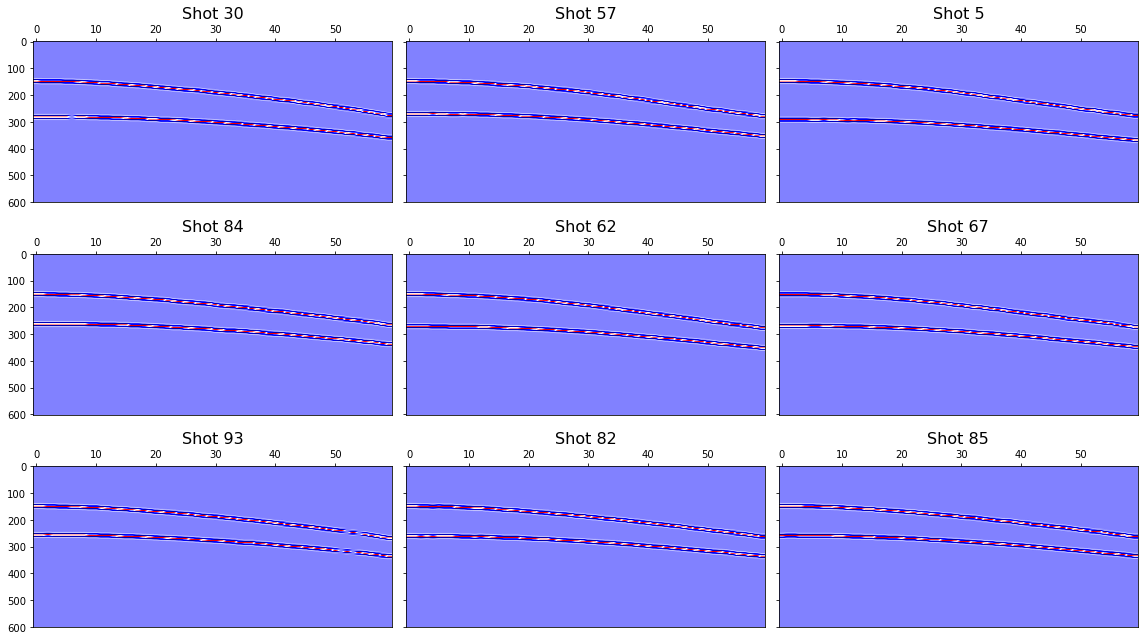

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(16,9), sharey=True)
axes = axes.flatten()

for i, ax in zip(disp_shots, axes):
    
    first_idx = i*n_rec
    last_idx = (i+1)*n_rec
    shot_data = data_corr[:, first_idx:last_idx]
    
    plot_seismic(shot_data, title=f"Shot {i+1}", ax=ax)


plt.tight_layout()
plt.show()

# CMP sorting and fold calculation

## Determine cmp station number for each trace

In [9]:
trace_cmp = []
trace_offset = []

for i in range(n_shots):
    
    # station number of shot
    shot_st = i + 1
    
    for j in range(n_rec):
        
        # station number of reciver
        rec_st = shot_st + j + 1
        
        # station number of cmp point
        cmp_st = (shot_st + rec_st) / 2
        
        # append to list
        trace_cmp.append(cmp_st)
        
        # offset - distance between source and receiver, in meters
        offset = abs(shot_st - rec_st) * dx
        
        # append to list
        trace_offset.append(offset)
        

# cast lists to numpy arrays
trace_cmp = np.array(trace_cmp)
trace_offset = np.array(trace_offset)

# store cmp station numbers in array
cmp_stations = np.unique(trace_cmp)

## Sort data for every CMP

In [10]:
cmp_gathers = {}

# iterate over cmp sations
for cmp in cmp_stations:
    
    # select relevant traces (and offsets) by masking, reverse order so shortest cmp on the left
    cmp_data = data_corr[:,trace_cmp == cmp][..., ::-1]
    
    # for every trace in cmp_data store its offset
    cmp_offsets = trace_offset[trace_cmp == cmp][::-1]
    
    # store in dict
    cmp_gathers[cmp] = {"data": cmp_data, "offsets": cmp_offsets}

## Plot fold

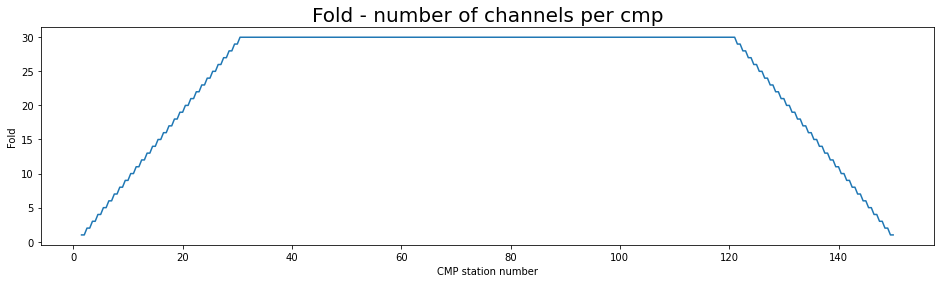

In [11]:
# calculate fold for each cmp by extracting number of columns (channels) in each gather
fold = np.array([g["data"].shape[1] for g in cmp_gathers.values()])

# plot
plt.figure(figsize=(16,4))
plt.plot(cmp_stations, fold)

plt.title("Fold - number of channels per cmp", fontdict={"size": 20})
plt.xlabel("CMP station number")
plt.ylabel("Fold")
plt.show()

## Plot selected gathers

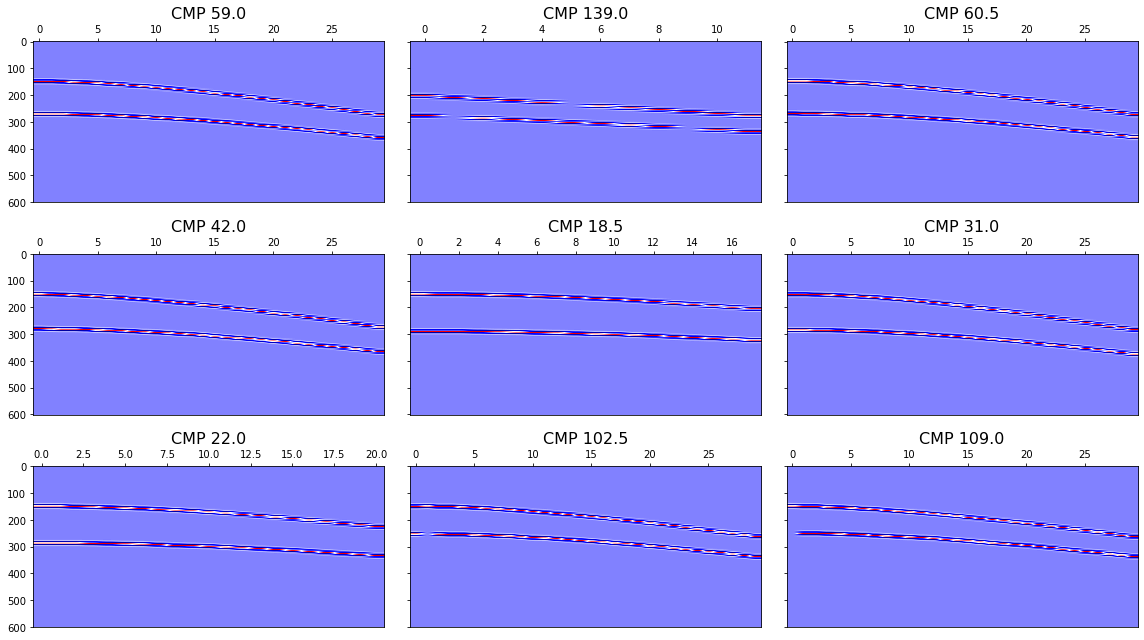

In [12]:
# randomly choose 9 cmp to display
disp_cmp = np.random.choice(cmp_stations, size=9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(16,9), sharey=True)
axes = axes.flatten()

for cmp, ax in zip(disp_cmp, axes):
    
    plot_seismic(cmp_gathers[cmp]["data"], title=f"CMP {cmp}", ax=ax)
    

plt.tight_layout()
plt.show()

# NMO correction for CMP gathers

In [13]:
cmp_gathers_corrected = {}

# iterate over cmp gathers
for cmp in cmp_stations:
    
    gather = cmp_gathers[cmp]
    gather_data = gather["data"]
    gather_offsets = gather["offsets"]
    
    # calculate t_nmo for each point in gather
    xx, tt = np.meshgrid(gather_offsets, times)
    
    # calculate corrected time after nmo
    t_nmo = np.sqrt( tt**2 + (xx / v)**2 )
    
    # convert t_nmo to index
    ii = (t_nmo / dt).round().astype(int)
    
    
    # iterate over traces in gather and shift values according to corrected index
    corrected_traces = [ ]
    
    for i in range(gather_data.shape[1]):
        
        # select trace and corresponding indexing array
        trace = gather_data[:, i]
        corrected_idx = ii[:, i]
        
        # remove indexes that are greater than number of samples 
        corrected_idx = corrected_idx[corrected_idx < n_samples]
        
        # slice trace to get only in corrected indexes position - this is the shift due to nmo correction
        corrected_tr = trace[corrected_idx]
        
        # append to list
        corrected_traces.append(pd.Series(corrected_tr))
        
    # concat corrected traces into 2d array
    corrected_gather = pd.concat(corrected_traces, axis=1).fillna(0)
    
    if corrected_gather.shape[0] < n_samples:
        
        n_rows = n_samples - corrected_gather.shape[0]
        zero_df = pd.DataFrame(np.zeros((n_rows, corrected_gather.shape[1])))
        corrected_gather = corrected_gather.append(zero_df, ignore_index=True)
        
    # cast to numpy array
    corrected_gather = corrected_gather.values
    
    
    ### stretch mute ###
    # compute strectch factor
    stretch_fac = (t_nmo/times[:,None] - 1)
    
    # if stretch factor is over 30 percent, insert 0
    corrected_gather_mute = np.where(stretch_fac < 0.3, corrected_gather, 0)
    
    
    # inset to dict
    cmp_gathers_corrected[cmp] = {"gather": corrected_gather, "gather_muted": corrected_gather_mute}

<ipython-input-13-67f218db0472>:53: RuntimeWarning: divide by zero encountered in true_divide
  stretch_fac = (t_nmo/times[:,None] - 1)


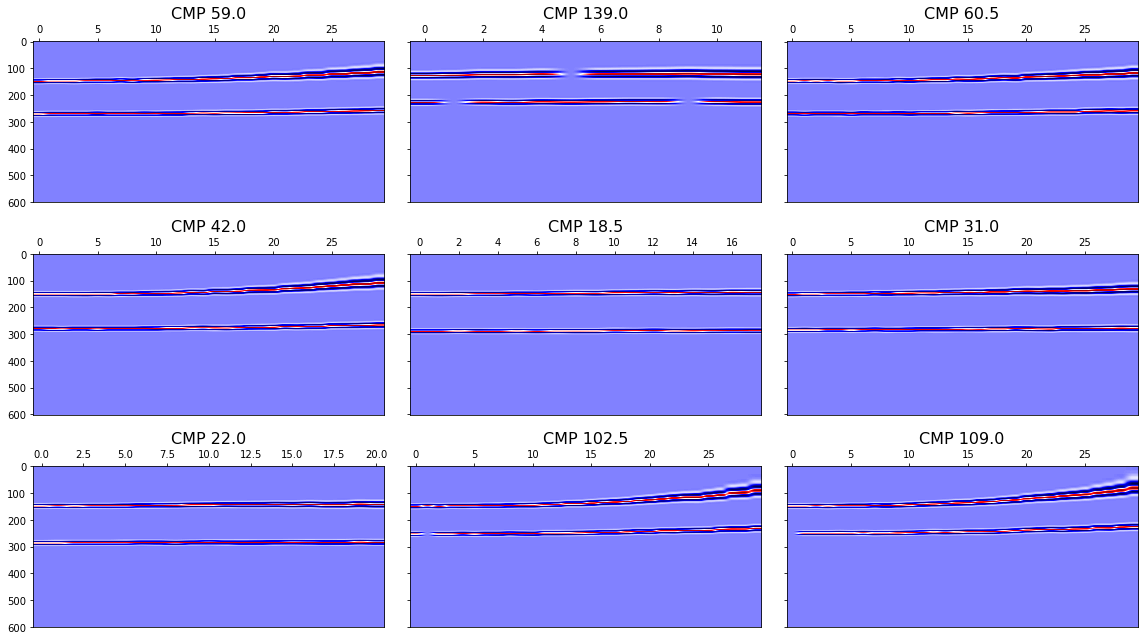

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(16,9), sharey=True)
axes = axes.flatten()

for cmp, ax in zip(disp_cmp, axes):
    
    plot_seismic(cmp_gathers_corrected[cmp]["gather"], title=f"CMP {cmp}", ax=ax)


plt.tight_layout()
plt.show()

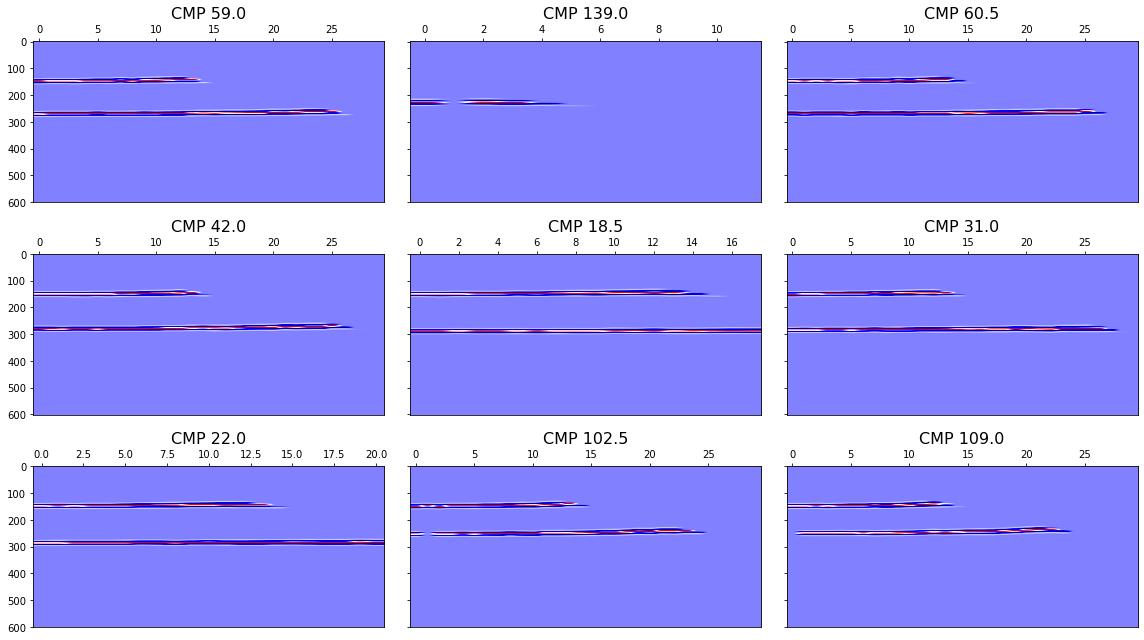

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(16,9), sharey=True)
axes = axes.flatten()

for cmp, ax in zip(disp_cmp, axes):
    
    plot_seismic(cmp_gathers_corrected[cmp]["gather_muted"], title=f"CMP {cmp}", ax=ax)


plt.tight_layout()
plt.show()

# Stack CMP gathers

In [16]:
stack = [pd.Series(cmp_gathers_corrected[cmp]["gather"].sum(axis=1)) for cmp in cmp_stations]

# concat stacked traces into 2d array
stack = pd.concat(stack, axis=1).fillna(0).values

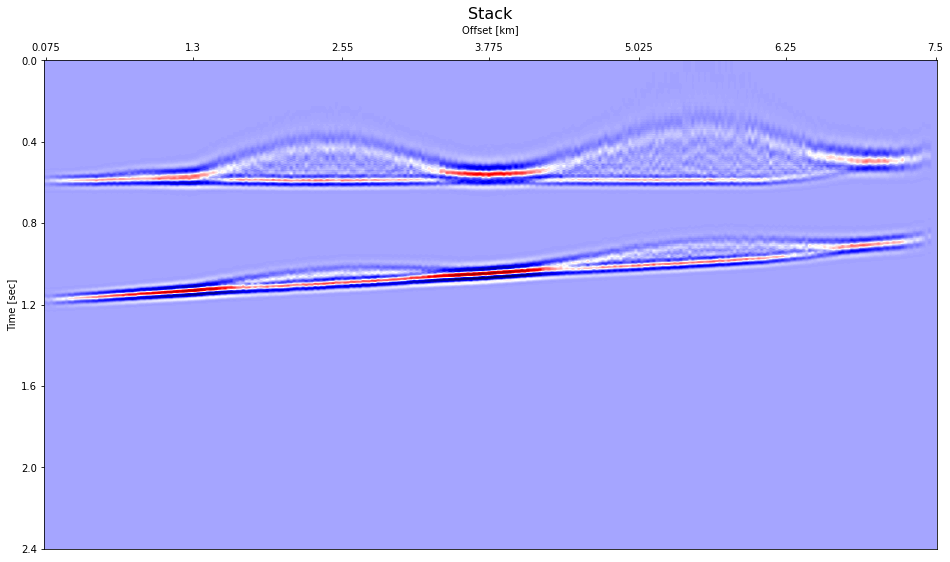

In [17]:
# plot
xticks = (cmp_stations * dx) / 1000
plot_seismic(stack, show_yticks=True, xticks=xticks, xlabel="Offset [km]", title="Stack")

In [18]:
stack_mute = [pd.Series(cmp_gathers_corrected[cmp]["gather_muted"].sum(axis=1)) for cmp in cmp_stations]

# concat stacked traces into 2d array
stack_mute = pd.concat(stack_mute, axis=1).fillna(0).values

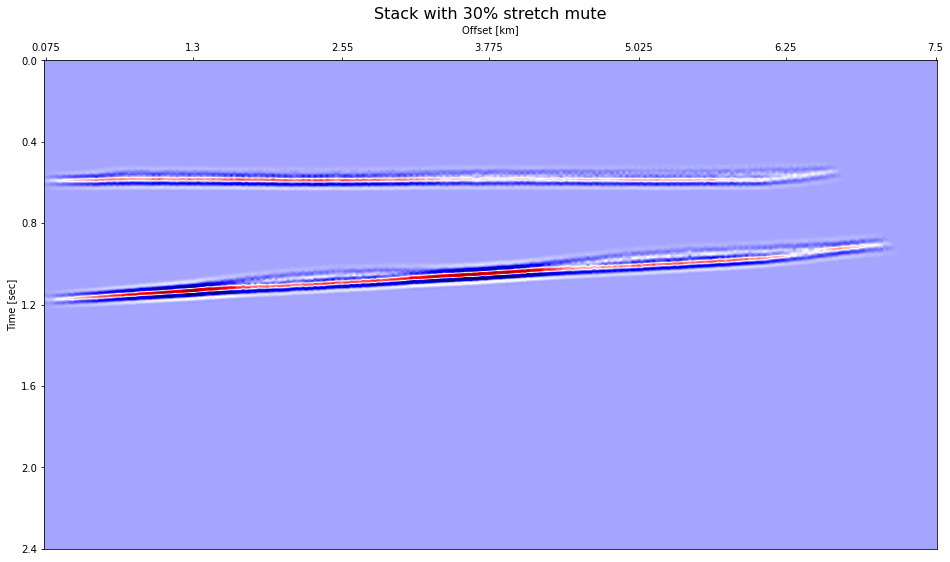

In [19]:
# plot
plot_seismic(stack_mute, show_yticks=True, xticks=xticks, xlabel="Offset [km]", title="Stack with 30% stretch mute")